# Conserving first integrals via manifold projection

As we saw in an [earlier example](<./Outer Solar System.ipynb>), even though heyoka.py is not a [symplectic integrator](https://en.wikipedia.org/wiki/Symplectic_integrator) it is nevertheless capable of optimally preserving conserved quantities in dynamical systems.

In order to conserve dynamical invariants, heyoka.py needs to be configured to operate at very low tolerances (i.e., below machine epsilon). High-precision numerical integrations however are computationally expensive, and in some contexts it is preferable, for performance reasons, to maintain a low integration accuracy while at the same time ensuring that the global dynamical invariants are preserved. This is the main reason why symplectic integrators are the tool of choice, for instance, in numerical studies of the long-term stability of extrasolar planetary systems.

In this example, we will show how we can enforce the conservation of dynamical invariants in high-tolerance numerical integrations with heyoka.py via a technique known as *manifold projection*.

## Setting things up

We will re-use here the setup described in the [outer Solar System example](<./Outer Solar System.ipynb>): a gravitational 6-body problem consisting of the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto with realistic initial conditions.

Let us begin by defining a few constants and the initial conditions:

In [1]:
import heyoka as hy
import numpy as np

# Masses, from Sun to Pluto.
masses = np.array([1.00000597682, 1 / 1047.355, 1 / 3501.6, 1 / 22869., 1 / 19314., 7.4074074e-09])

# The gravitational constant.
G = 0.01720209895 * 0.01720209895 * 365 * 365

# Initial conditions.
ic = [# Sun.
      -4.06428567034226e-3, -6.08813756435987e-3, -1.66162304225834e-6, +6.69048890636161e-6 * 365,
      -6.33922479583593e-6 * 365, -3.13202145590767e-9 * 365,
      # Jupiter.
      +3.40546614227466e+0, +3.62978190075864e+0, +3.42386261766577e-2, -5.59797969310664e-3 * 365,
      +5.51815399480116e-3 * 365, -2.66711392865591e-6 * 365,
      # Saturn.
      +6.60801554403466e+0, +6.38084674585064e+0, -1.36145963724542e-1, -4.17354020307064e-3 * 365,
      +3.99723751748116e-3 * 365, +1.67206320571441e-5 * 365,
      # Uranus.
      +1.11636331405597e+1, +1.60373479057256e+1, +3.61783279369958e-1, -3.25884806151064e-3 * 365,
      +2.06438412905916e-3 * 365, -2.17699042180559e-5 * 365,
      # Neptune.
      -3.01777243405203e+1, +1.91155314998064e+0, -1.53887595621042e-1, -2.17471785045538e-4 * 365,
      -3.11361111025884e-3 * 365, +3.58344705491441e-5 * 365,
      # Pluto.
      -2.13858977531573e+1, +3.20719104739886e+1, +2.49245689556096e+0, -1.76936577252484e-3 * 365,
      -2.06720938381724e-3 * 365, +6.58091931493844e-4 * 365]

See the [outer Solar System example](<./Outer Solar System.ipynb>) for more details on the setup.

Next, we setup the dynamical equations of our N-body problem:

In [2]:
# Define the ODEs.
sys = hy.model.nbody(6, masses = masses, Gconst = G)

We also store the 36 state variables (3 Cartesian positions and 3 Cartesian velocities for each of the 6 bodies) in a list for later use:

In [3]:
state_vars = [p[0] for p in sys]

Next, we define a [compiled function](./compiled_functions.ipynb) for the rapid computation of the energy of the system from the state vector. Here we are using the ``model.nbody_energy()`` helper, which creates the symbolic formula for the energy constant in the N-body problem:

In [4]:
# Define a compiled function for the computation
# of the energy in an N-body system from its state vector.
en_cfunc = hy.make_cfunc([hy.model.nbody_energy(6, masses=masses, Gconst=G)],
                         vars=state_vars)

We can now proceed to the instantiation of the numerical integrator. We choose a high tolerance of $10^{-6}$, so that the integrator will not be able to enforce energy conservation on its own (since we are not operating at sub-epsilon tolerances):

In [5]:
ta = hy.taylor_adaptive(sys, ic, tol = 1e-6)

Let us now compute the initial energy of the system:

In [6]:
print(f"Initial energy: {en_cfunc(ta.state)[0]}")

Initial energy: -0.004286848855986956


So far so good (though perhaps not very exciting).

The next step is the introduction of a callback to be invoked after every step taken by the numerical integrator. This callback will check the relative energy error, and stop the integration if the error exceeds the $10^{-6}$ threshold:

In [7]:
class proj_callback:
    def __init__(self, ta):
        # Store the initial energy value
        # as a data member.
        self.E0 = en_cfunc(ta.state)[0]
    def __call__(self, ta):
        # Compute the relative energy error
        # wrt the initial energy value.
        rel_err = abs((en_cfunc(ta.state)[0]-self.E0)/self.E0)
        
        # Stop if the error is greater than 1e-6.
        if rel_err > 1e-6:
            print(f"Rel energy error: {rel_err}")
            return False
        else:
            return True

Let us now integrate until the energy error reaches the threshold:

In [8]:
cb = proj_callback(ta)
# Attempt to propagate the state of the
# system for 1000 years.
ta.propagate_until(1000., callback = cb)

Rel energy error: 1.1480506382380454e-06


(<taylor_outcome.cb_stop: -4294967301>,
 0.7296940138544892,
 1.058372251981769,
 36,
 None)

We can see from the output that indeed the integration was terminated earlier because of the callback (as indicated by the ``taylor_outcome.cb_stop`` outcome), and that the error threshold was exceeded after 36 steps.

## Fixing the energy

We can now move to the interesting part, that is, enforcing energy conservation. The basic idea is to alter the current state vector of the system (whose energy has drifted away from the initial value) so that the energy of the updated state vector matches the initial energy of the system.

Because there are infinite points in phase space whose energy is equal to the initial value, we impose the additional constraint that the updated state vector should be as close as possible to the original one. In other words, we are projecting the position in phase space of the current state vector onto the hyper-surface (manifold) defined by the conservation of energy.

This projection process can be seen as a [constrained optimisation problem](https://en.wikipedia.org/wiki/Constrained_optimization): we want to minimise the distance from the original state vector subject to the constraint that the updated state vector must lie on the manifold defined by the conservation of energy.

Let us begin with the definition of the objective function:

In [9]:
def objfun(x):
    return np.sum((x - ta.state)**2)

As mentioned above, here we are trying to minimise the distance (in phase space) between the original state vector (``ta.state``) and the updated state vector (``x``).

Next, we define the constraint:

In [10]:
def cstr_fun(x):
    return en_cfunc(x)[0] - cb.E0

This equality constraint is satisifed if ``cstr_fun()`` returns zero, that is, if the energy of the updated state vector (``x``) is equal to the initial energy of the system (stored in the callback as ``cb.E0``).

We are now ready to run the optimisation via {func}`scipy.optimize.minimize()`. Note that we need an optimiser with support for constraints (here we choose ``'SLSQP'``):

In [11]:
from scipy.optimize import minimize
ret = minimize(objfun, ta.state, method='SLSQP',
               tol=1e-10,
               constraints=[{'type' : 'eq', 'fun' : cstr_fun}])

# Store the updated state vector.
res=ret.x
print(ret)

     fun: 1.6028684440203444e-12
     jac: array([ 3.11251986e-08, -4.02708781e-07, -2.46777679e-09,  6.77127979e-07,
        1.08545922e-07,  6.47440813e-09, -1.78846684e-08,  4.43699859e-07,
        2.04735758e-09, -8.41776918e-07, -7.41579788e-08, -4.55326934e-09,
       -1.49170933e-08, -4.19038955e-08,  6.20362206e-10,  1.87868576e-07,
       -6.28733494e-08, -1.69663797e-09,  1.65726277e-09,  5.62154767e-10,
        1.03364983e-10, -5.76595893e-09,  2.04608148e-08,  2.42488338e-10,
        3.90553367e-10,  7.21875892e-10,  6.79805101e-11, -1.70828227e-08,
        8.39227743e-09, -9.86619363e-11,  7.43582973e-11,  7.42426121e-11,
        7.42428341e-11,  7.37144790e-11,  7.71662734e-11,  7.41105788e-11])
 message: 'Optimization terminated successfully'
    nfev: 76
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 3.84105755e-04,  4.20825164e-03,  5.43036572e-05, -2.08872689e-03,
       -3.34644025e-04, -1.97521288e-05,  2.12415778e-01, -5.23285648e+00,
       -

We can see how the optimisation terminated successfully.

Let us verify that the updated state vector (``res``) conserves energy with a better accuracy than the original state vector:

In [12]:
print(f"Original energy error: {abs((en_cfunc(ta.state)[0] - cb.E0)/cb.E0)}")
print(f"Updated  energy error: {abs((en_cfunc(res)[0] - cb.E0)/cb.E0)}")

Original energy error: 1.1480506382380454e-06
Updated  energy error: 1.3943225305580199e-11


## Helping the optimiser out

Optimisation algorithms can greatly benefit from the availability of gradients for the objective function and the constraints. Luckily, heyoka.py's expression system lets us compute derivatives without too much pain.

Let us begin by defining a symbolic expression representing the square of the distance between the original state vector and the updated state vector. Here, the original state vector will be represented by the symbolic state variables (stored earlier in ``state_vars``) and the updated state vector will be passed in the array of [runtime parameters](<./ODEs with parameters.ipynb>):

In [13]:
dist2_ex = hy.sum_sq([state_vars[i] - hy.par[i] for i in range(36)])

Let us take a look at ``dist2_ex`` just to fix the ideas:

In [14]:
dist2_ex

((x_0 - p0)**2 + (y_0 - p1)**2 + (z_0 - p2)**2 + (vx_0 - p3)**2 + (vy_0 - p4)**2 + (vz_0 - p5)**2 + (x_1 - p6)**2 + (y_1 - p7)**2 + (z_1 - p8)**2 + (vx_1 - p9)**2 + (vy_1 - p10)**2 + (vz_1 - p11)**2 + (x_2 - p12)**2 + (y_2 - p13)**2 + (z_2 - p14)**2 + (vx_2 - p15)**2 + (vy_2 - p16)**2 + (vz_2 - p17)**2 + (x_3 - p18)**2 + (y_3 - p19)**2 + (z_3 - p20)**2 + (vx_3 - p21)**2 + (vy_3 - p22)**2 + (vz_3 - p23)**2 + (x_4 - p24)**2 + (y_4 - p25)**2 + (z_4 - p26)**2 + (vx_4 - p27)**2 + (vy_4 - p28)**2 + (vz_4 - p29)**2 + (x_5 - p30)**2 + (y_5 - p31)**2 + (z_5 - p32)**2 + (vx_5 - p33)**2 + (vy_5 - p34)**2 + (vz_5 - p35)**2)

We can now compute symbolically the gradient vector of ``dist2_ex``:

In [15]:
grad_dist2_ex = list(hy.diff(dist2_ex, state_vars[i]) for i in range(36))
grad_dist2_ex

[(2.0000000000000000 * (x_0 - p0)),
 (2.0000000000000000 * (y_0 - p1)),
 (2.0000000000000000 * (z_0 - p2)),
 (2.0000000000000000 * (vx_0 - p3)),
 (2.0000000000000000 * (vy_0 - p4)),
 (2.0000000000000000 * (vz_0 - p5)),
 (2.0000000000000000 * (x_1 - p6)),
 (2.0000000000000000 * (y_1 - p7)),
 (2.0000000000000000 * (z_1 - p8)),
 (2.0000000000000000 * (vx_1 - p9)),
 (2.0000000000000000 * (vy_1 - p10)),
 (2.0000000000000000 * (vz_1 - p11)),
 (2.0000000000000000 * (x_2 - p12)),
 (2.0000000000000000 * (y_2 - p13)),
 (2.0000000000000000 * (z_2 - p14)),
 (2.0000000000000000 * (vx_2 - p15)),
 (2.0000000000000000 * (vy_2 - p16)),
 (2.0000000000000000 * (vz_2 - p17)),
 (2.0000000000000000 * (x_3 - p18)),
 (2.0000000000000000 * (y_3 - p19)),
 (2.0000000000000000 * (z_3 - p20)),
 (2.0000000000000000 * (vx_3 - p21)),
 (2.0000000000000000 * (vy_3 - p22)),
 (2.0000000000000000 * (vz_3 - p23)),
 (2.0000000000000000 * (x_4 - p24)),
 (2.0000000000000000 * (y_4 - p25)),
 (2.0000000000000000 * (z_4 - p26)),

Shocking, I know.

We can now proceed to create a compiled function that will concatenate in a single vector output the value of the distance square and its gradient vector:

In [16]:
objfun_cfunc = hy.make_cfunc([dist2_ex] + grad_dist2_ex, vars=state_vars)

Finally, we can define an updated objective function that, in addition to returning the distance square, will return also its gradient vector (in the format required by {func}`scipy.optimize.minimize()`, i.e., as a tuple of 2 values):

In [17]:
def objfun(x):
    ret = objfun_cfunc(x, pars=ta.state)
    
    # Return the distance square and its
    # gradient as a tuple of 2 values.
    return (ret[0], ret[1:])

In a similar fashion, we can define a compiled function for the computation of the gradient of the constraint:

In [18]:
# The symbolic expression representing the energy
# of the system.
en_ex = hy.model.nbody_energy(6, masses=masses, Gconst=G)

# The gradient of the energy.
grad_cstr = list(hy.diff(en_ex, state_vars[i]) for i in range(36))

# The compiled function for the computation of the gradient
# of the constraint.
grad_cstr_cfunc = hy.make_cfunc(grad_cstr, vars=state_vars)

We can now put everything together, and invoke again {func}`scipy.optimize.minimize()` supplying the gradients:

In [19]:
ret = minimize(objfun, ta.state, method='SLSQP', tol=1e-10,
               jac=True,
               constraints=[{'type' : 'eq', 'fun' : cstr_fun, 'jac' : grad_cstr_cfunc}])

res=ret.x
print(ret)

     fun: 1.6028685201955344e-12
     jac: array([ 3.12048208e-08, -4.04779376e-07, -2.55461938e-09,  6.80411912e-07,
        1.09011735e-07,  6.43432025e-09, -1.80479259e-08,  4.45824393e-07,
        1.98289293e-09, -8.46023687e-07, -7.46001427e-08, -4.65041808e-09,
       -1.50656865e-08, -4.21861941e-08,  5.48796397e-10,  1.88725123e-07,
       -6.32595809e-08, -1.77965358e-09,  1.59084834e-09,  4.90336660e-10,
        2.92618152e-11, -5.86914850e-09,  2.04876218e-08,  1.69083272e-10,
        3.17850635e-10,  6.50835830e-10, -6.30695496e-12, -1.72421082e-08,
        8.35925729e-09, -1.73769565e-10,  9.23705556e-14,  2.22044605e-15,
       -2.48689958e-14, -5.33240119e-13,  2.93010061e-12, -1.41706091e-13])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 3.84105829e-04,  4.20825171e-03,  5.43037301e-05, -2.08872682e-03,
       -3.34643957e-04, -1.97520606e-05,  2.12415778e-01, -5.23285648e+00,
       -2

Like before, the optimisation completed successfully, this time taking far fewer objective function evaluations thanks to the availability of the gradient (which was previously estimated via numerical differencing).

We can again verify that the updated state vector (``res``) conserves energy with a better accuracy than the original state vector:

In [20]:
print(f"Original energy error: {abs((en_cfunc(ta.state)[0] - cb.E0)/cb.E0)}")
print(f"Updated  energy error: {abs((en_cfunc(res)[0] - cb.E0)/cb.E0)}")

Original energy error: 1.1480506382380454e-06
Updated  energy error: 1.3842059884646701e-11


## Packaging it all together

As a last step, we now incorporate manifold projection into the step callback, so that we can automatically ensure energy conservation whenever the energy error drifts too far during the numerical integration.

Here is the updated version of the callback:

In [21]:
class proj_callback:
    def __init__(self, ta):
        # Store the initial energy value
        # as a data member.
        self.E0 = en_cfunc(ta.state)[0]
        
        # Setup a variable to count how many times
        # we perform manifold projection.
        self.n_proj = 0
    def __call__(self, ta):
        # Compute the relative energy error
        # wrt the initial energy value.
        rel_err = abs((en_cfunc(ta.state)[0]-self.E0)/self.E0)
        
        # Fix the energy if the error is greater than 1e-6.
        if rel_err > 1e-6:
            ret = minimize(objfun, ta.state, method='SLSQP', tol=1e-10,
                           jac=True,
                           constraints=[{'type' : 'eq', 'fun' : cstr_fun,
                                         'jac' : grad_cstr_cfunc}])
            if ret.status != 0:
                print(f"Optimisation returned nonzero status:\n{ret}")
                return False
            
            # Update the state vector.
            ta.state[:] = ret.x
            
            # Update the counter.
            self.n_proj += 1

        return True

Let us now reset the state of the integrator back to the original initial conditions:

In [22]:
ta.state[:] = ic
ta.time = 0.

We are now ready to repeat the numerical integration with automatic manifold projection. We will propagate the state of the system over an equispaced time grid up to $10^5$ years:

In [23]:
# Create the callback object.
cb = proj_callback(ta)

# Define the time grid.
t_grid = np.linspace(0, 1e5, 1000)

# Run the numerical integration.
pres_proj = ta.propagate_grid(t_grid, callback=cb)

Let us also run a numerical integration without projection for comparison:

In [24]:
ta.state[:] = ic
ta.time = 0.

pres_noproj = ta.propagate_grid(t_grid)

We can now take a look at the results:

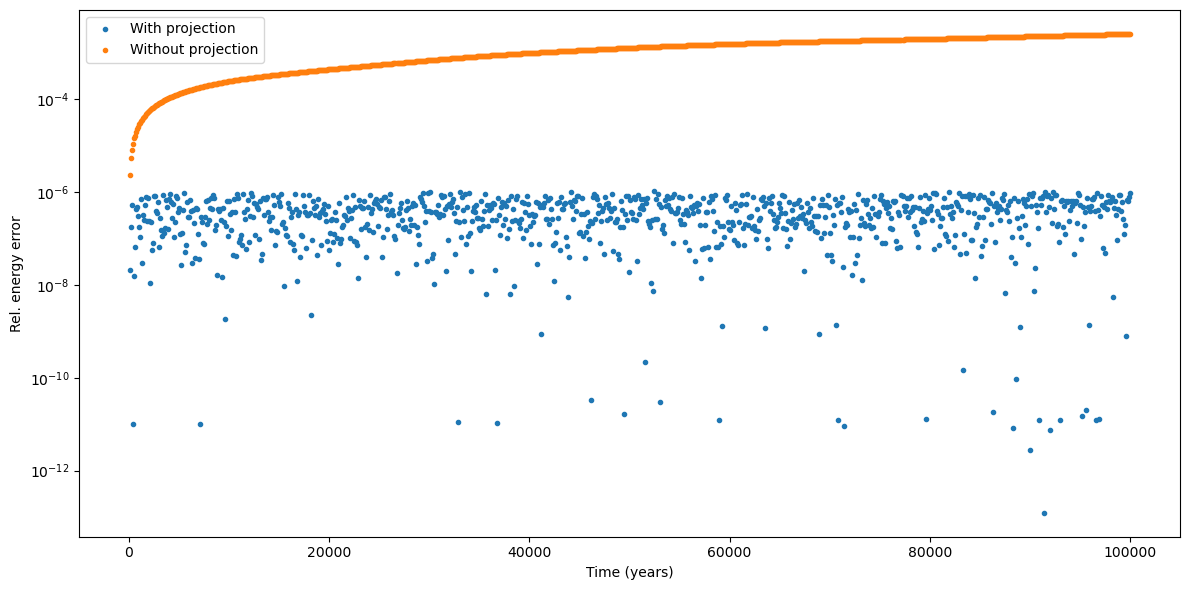

In [25]:
from matplotlib.pylab import plt
fig = plt.figure(figsize = (12, 6))

# Use log scale on the y axis.
plt.yscale('log')

# Compute the energy error over the time grid.
err_proj_hist = abs((cb.E0 - en_cfunc(pres_proj[-1].transpose())[0])/cb.E0)
err_noproj_hist = abs((cb.E0 - en_cfunc(pres_noproj[-1].transpose())[0])/cb.E0)

plt.plot(t_grid, err_proj_hist, marker='.', linestyle='None', label="With projection")
plt.plot(t_grid, err_noproj_hist, marker='.', linestyle='None', label="Without projection")

plt.xlabel("Time (years)")
plt.ylabel("Rel. energy error")
plt.legend()
plt.tight_layout();

We can indeed see how the energy error with projection is kept under the $10^{-6}$ threshold.

We can also take a look at the number of manifold projections performed throughout the integration and compare it to the total number of steps:

In [26]:
print(f"Number of projections: {cb.n_proj}")
print(f"Number of steps: {pres_proj[3]}")

Number of projections: 3765
Number of steps: 108881
